In [3]:
from dataset import DeezerDataset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Background

In this project, we aim to explore the Deezer Europe social network (https://snap.stanford.edu/data/feather-deezer-social.html). The network consists of Deezer users which was collected from the public API in March 2020. Nodes are Deezer users from European countries and edges are mutual follower relationships between them. The vertex features are extracted based on the artists liked by the users. The task related to the graph is binary node classification - one has to predict the gender of users. This target feature was derived from the name field for each user.

There are 28281 users and 31241 artists in this dataset, resulting in a ~28000 x 31000 feature matrix.

The github repository of this project can be found at https://github.com/Weijiang-Xiong/NML23-Project.

# Progress

* First, we explored various aspects of the network, evaluated its degree distribution and network properties. This step is to help us better understand the network in general.
* Second, we completed various **data preprocessing and node embedding** pipelines. Since the original dataset come in json format, we first transformed it into dataset class compatible with PyG or networkx format. We implemented multiple node embedding techniques, including node2vec, feather or using the raw features.
* Third, we built a baseline model of graph convolutional neural network for the binary node classification task. 

## Part 1: Network Exploration
In this section, we aim to explore various properties of the network to help us better understand its behavior.

First, we load the graph as a networkx graph based on a custom class called DeezerDataset we developed.

In [3]:
# Load DeezerDataset as a networkx graph
test = DeezerDataset("./data/", from_raw=True, method=None, save_data=True)
G = test.process_raw_feature()

We now plot its degree distribution.

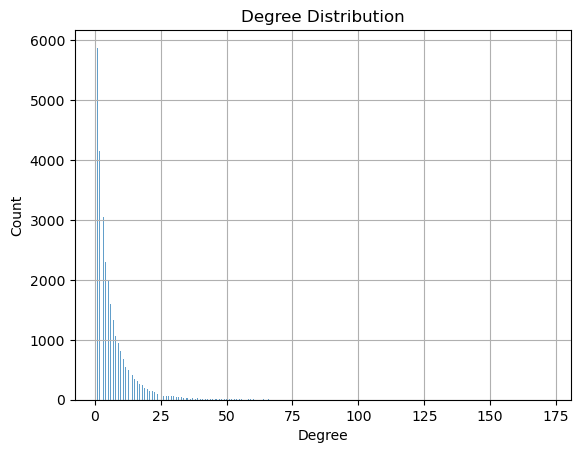

In [4]:
# degree distribution
degrees = [G.degree(node) for node in G.nodes()]
plt.hist(degrees, bins='auto', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.grid(True)
plt.show()

From the degree distribution figure, it can be seen that in the network most nodes have low connections, but different from scale-free network, there are no nodes with relatively higher connections. We can calulate its shortest path length and average clustering:

In [17]:
print(f'Average shortest path length is {nx.average_shortest_path_length(G)}')
print(f'Average clustering is {nx.average_clustering(G)}')



Average shortest path length is 6.449804500370024
Average clustering is 0.14115987333165492


The network at hand has low clustering and relatilvely high average shortest path length, thus do not entirely follow the scale-free network model. We can use a Barabasi-Albert network model to simulate the network:

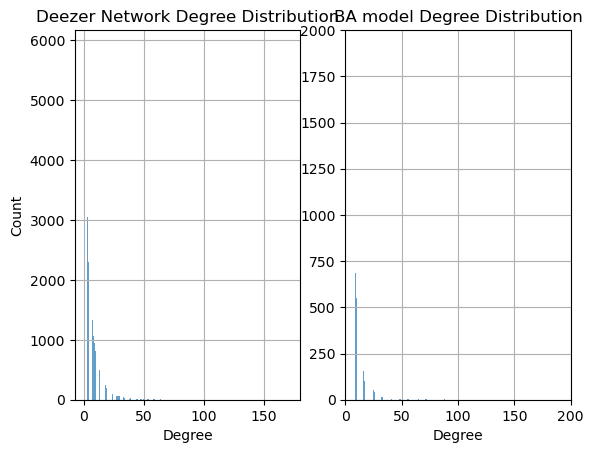

In [11]:
q = np.round(np.mean(degrees)/2).astype(np.int32)
G_ba = nx.barabasi_albert_graph(G.number_of_nodes(), q)

degrees_ba = [G_ba.degree(node) for node in G_ba.nodes()]
plt.subplot(1,2,2)
plt.hist(degrees_ba, bins='auto', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('BA model Degree Distribution')
plt.grid(True)
plt.xlim(0, 200)
plt.ylim(0, 2000)

plt.subplot(1,2,1)
plt.hist(degrees, bins='auto', alpha=0.7)
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Deezer Network Degree Distribution')
plt.grid(True)

plt.show()

Next, we perform a label anlysis for the classification task.

In [7]:
# Load dataset as a pyg graph
Data = DeezerDataset("./data/", from_raw=False, save_data=False)

Using the provided dataset from PyTorch Geometric
Keeping the data in memory, linked to self._processed_data


Processing...
Done!


In [12]:
print(f'Proportion of gender division is {sum(Data.y) / len(Data.y)}')

Proportion of gender division is 0.44333651661872864


Thus we can see that labels in this classification task are basically balanced.

## Part 2: Model training

In this part we train a baseline GCN model on the network for user gender classification. We use 80% of the nodes for training, 10% for validation and test respectively.

The following command will train a GCN model with hidden dimension 64 for 200 epochs/iterations, and the learning rate and weight decay in the optimizer are set to 0.0001 and 0.001 respectively.

By default, the features are transformed to 128 dimensions using truncated SVD.

In [13]:
!python train_net.py --model gcn --hid-dim 64 --max-epoch 200 --learning-rate 0.0001 --weight-decay 0.001

Using these configurations
Namespace(data_root='./data', from_raw=False, method=None, save_data=False, model='gcn', hid_dim=64, max_epoch=200, learning_rate=0.0001, weight_decay=0.001)

Device:  cpu
Processing...
Using the provided dataset from PyTorch Geometric
Keeping the data in memory, linked to self._processed_data
Done!
Using model class GCN
Detailed Model Definition:
GCN(
  (graphconv1): GCNConv(128, 64)
  (graphconv2): GCNConv(64, 64)
  (graphconv3): GCNConv(64, 2)
)
Epoch: 000, Train Loss: 0.750, Val Acc: 0.453
Epoch: 010, Train Loss: 0.727, Val Acc: 0.453
Epoch: 020, Train Loss: 0.713, Val Acc: 0.463
Epoch: 030, Train Loss: 0.704, Val Acc: 0.488
Epoch: 040, Train Loss: 0.700, Val Acc: 0.514
Epoch: 050, Train Loss: 0.694, Val Acc: 0.543
Epoch: 060, Train Loss: 0.694, Val Acc: 0.544
Epoch: 070, Train Loss: 0.692, Val Acc: 0.547
Epoch: 080, Train Loss: 0.691, Val Acc: 0.553
Epoch: 090, Train Loss: 0.689, Val Acc: 0.560
Epoch: 100, Train Loss: 0.687, Val Acc: 0.559
Epoch: 110, Tr

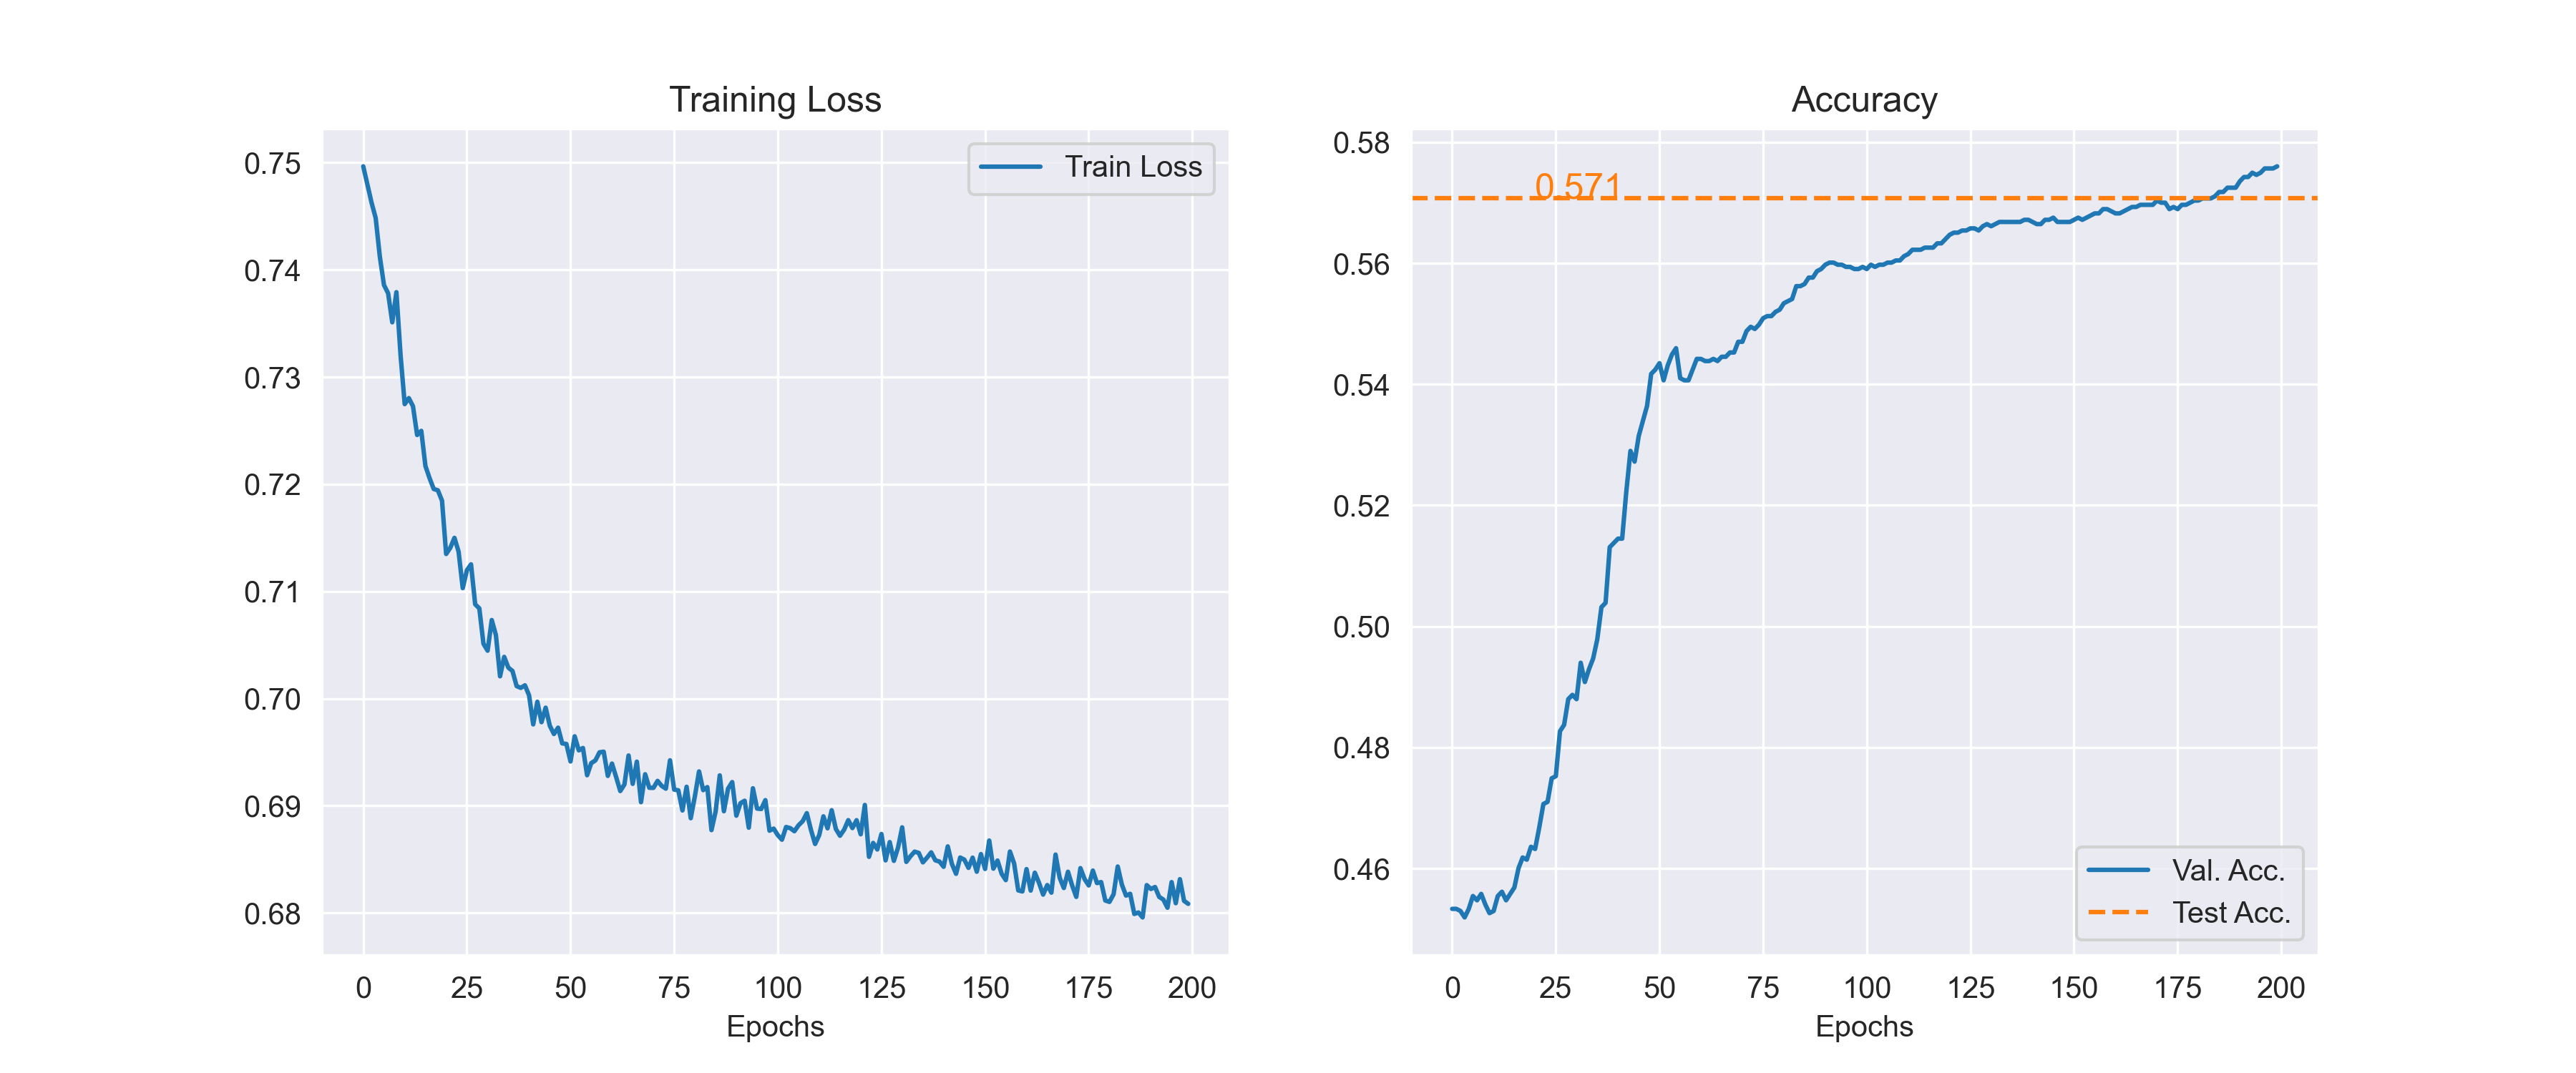

In [16]:
from IPython.display import Image, display
display(Image(filename='figs/training_log_None.png'))